In this notebook, we demonstrate the issue with using a single Monte Carlo sample in the gradient estimation step.

In [91]:
import numpy as np
import pymc as pm
import pytensor
pytensor.config.cxx = '/usr/bin/clang++'

In [101]:
mu_prior, sigma_prior = 0, 10
sigma_like = 1.0
optimizer = pm.adagrad_window(learning_rate=1e-1, n_win=3)
max_iters = 15000
with pm.Model() as single_model:
    # Define priors
    mu = pm.Normal("mu", mu_prior, sigma_prior)
    likelihood = pm.Normal(
        'y',
        mu=mu,
        sigma=sigma_like,
        observed=np.array([]))
    advi = pm.ADVI(random_seed=10)
    single_tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
    single_fit = advi.fit(
        max_iters, callbacks=[single_tracker],
        obj_optimizer=optimizer, obj_n_mc=1,
    )

with pm.Model() as multi_model:
    # Define priors
    mu = pm.Normal("mu", mu_prior, sigma_prior)
    likelihood = pm.Normal('y', mu=mu, sigma=sigma_like, observed=np.array([]))
    advi_2 = pm.ADVI(random_seed=10)
    multi_tracker = pm.callbacks.Tracker(
            mean = advi_2.approx.mean.eval,
            std = advi_2.approx.std.eval
        )
    multi_fit = advi_2.fit(
        max_iters, callbacks=[multi_tracker],
        obj_optimizer=optimizer, obj_n_mc=1000,
    )

/Users/madelynandersen/miniconda3/envs/pymc_env_pm/lib/python3.11/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Finished [100%]: Average Loss = 0.0078925


/Users/madelynandersen/miniconda3/envs/pymc_env_pm/lib/python3.11/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Finished [100%]: Average Loss = 3.0616e-06


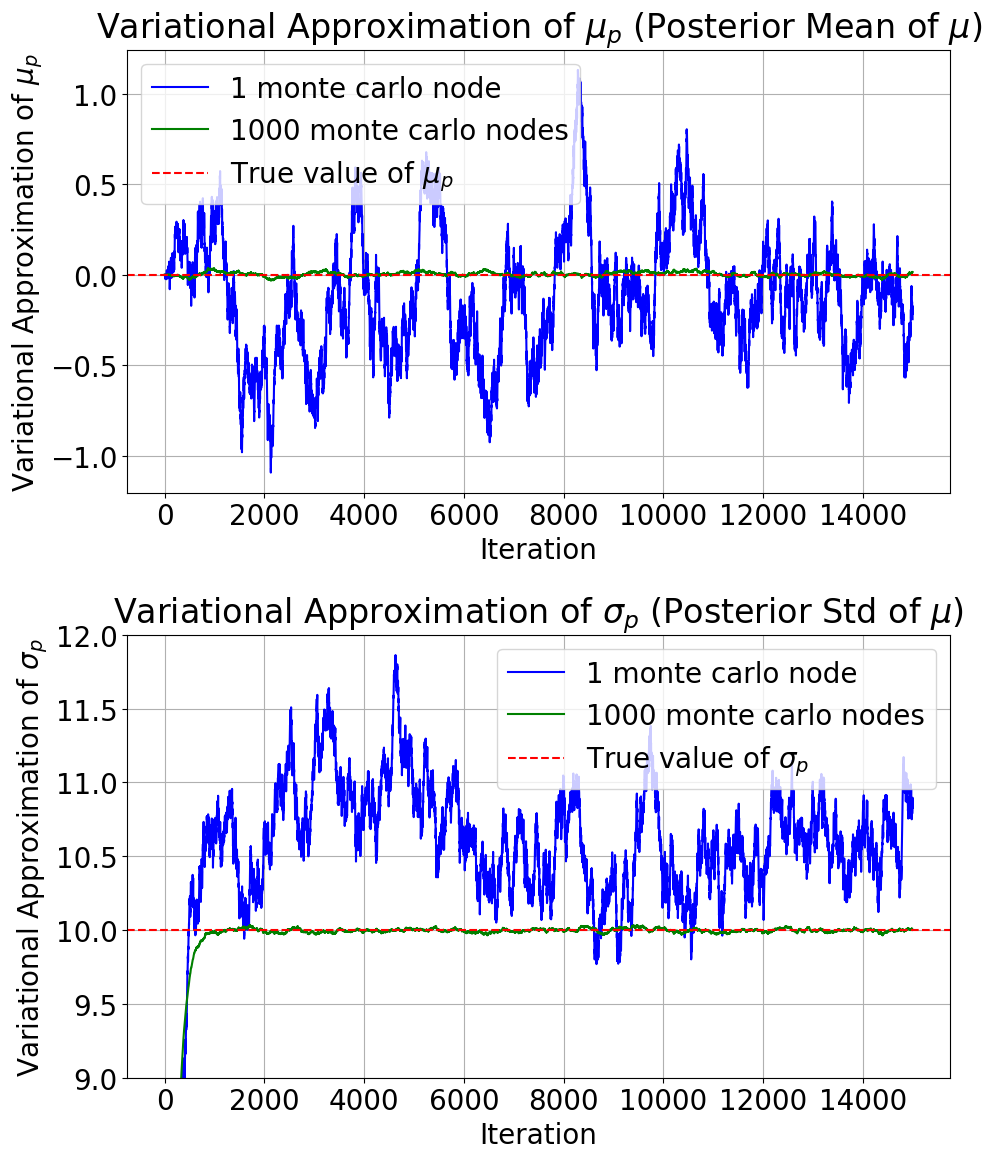

In [102]:
# plot single_tracker vs multi_tracker for the mean and std of mu
# add dashed lines for true values of mu mean and std which is N(0, 1)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# set font size to 14
plt.rcParams.update({'font.size': 20})

axs[0].plot(single_tracker['mean'], label='1 monte carlo node', color='blue')
axs[0].plot(multi_tracker['mean'], label='1000 monte carlo nodes', color='green')
axs[0].axhline(mu_prior, color='red', linestyle='--', label=r'True value of $\mu_p$')
axs[0].set_title(r'Variational Approximation of $\mu_p$ (Posterior Mean of $\mu$)')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel(r'Variational Approximation of $\mu_p$')
axs[0].legend()
axs[0].grid()

axs[1].plot(single_tracker['std'], label='1 monte carlo node', color='blue')
axs[1].plot(multi_tracker['std'], label='1000 monte carlo nodes', color='green')
axs[1].axhline(sigma_prior, color='red', linestyle='--', label=r'True value of $\sigma_p$')
axs[1].set_title(r'Variational Approximation of $\sigma_p$ (Posterior Std of $\mu$)')
axs[1].set_xlabel('Iteration', fontsize=20)
axs[1].set_ylabel(r'Variational Approximation of $\sigma_p$')
axs[1].legend()
axs[1].grid()
axs[1].set_ylim(sigma_prior - 1, sigma_prior + 2)

plt.tight_layout()
plt.show()